In [71]:
import pandas as pd
import numpy as np, networkx as nx
from concurrent.futures import ThreadPoolExecutor, as_completed

Found 74762 missing max_velocity segments.
✅ Imputed 1872 segments from neighbors.
✅ Filled remaining NaNs using street-level medians.


/Users/davestran/Desktop/CS-3331/World-Model-Project/worldmodel31/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/davestran/Desktop/CS-3331/World-Model-Project/worldmodel31/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/davestran/Desktop/CS-3331/World-Model-Project/worldmodel31/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/davestran/Desktop/CS-3331/World-Model-Project/worldmodel31/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/davestran/Desktop/CS-3331/World-Model-Project/worldmodel31/lib/python3.12/site-packages/n

valid_neighbors
0    202
1     58
2     56
7      9
5      9
4      9
6      4
3      3
8      2
9      1
Name: count, dtype: int64


/var/folders/29/z23p094n72q2wj4myl4pf29w0000gn/T/ipykernel_91720/3251232054.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_nan['valid_neighbors'] = final_nan['_id'].apply(count_valid_neighbors)


✅ Remaining NaN after fallback: 0


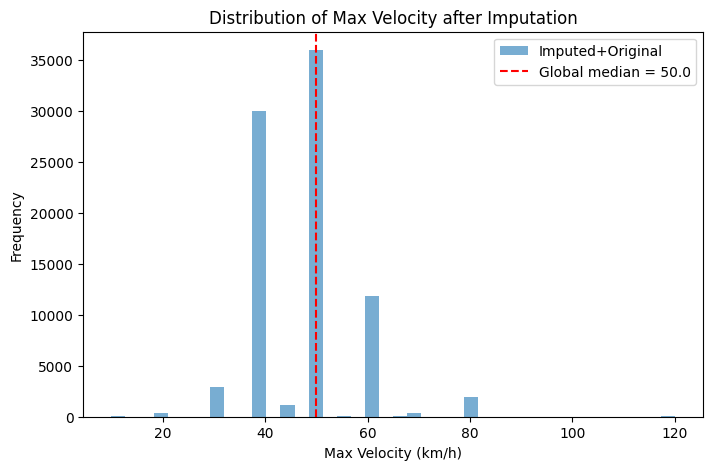

In [72]:
nodes = pd.read_csv("hcm_city_data/nodes.csv")
segs = pd.read_csv("hcm_city_data/segments.csv")
streets = pd.read_csv("hcm_city_data/streets.csv")
segment_status = pd.read_csv("hcm_city_data/segment_status.csv")

from concurrent.futures import ThreadPoolExecutor, as_completed

def get_neighbors(sid):
    u, v = seg_id_to_uv[sid]
    neigh = set()
    for x in G.predecessors(u): neigh.add(uv_to_seg_id.get((x, u)))
    for x in G.successors(u):   neigh.add(uv_to_seg_id.get((u, x)))
    for x in G.predecessors(v): neigh.add(uv_to_seg_id.get((x, v)))
    for x in G.successors(v):   neigh.add(uv_to_seg_id.get((v, x)))
    neigh.discard(None)
    neigh.discard(sid)
    return sid, list(neigh)

adj_map = {}
sids = list(seg_id_to_uv.keys())

with ThreadPoolExecutor(max_workers=8) as ex:
    futures = [ex.submit(get_neighbors, sid) for sid in sids]
    for f in as_completed(futures):
        sid, neigh = f.result()
        adj_map[sid] = neigh
        
nan_mask = segs['max_velocity'].isna()
nan_segs = segs[nan_mask]
print(f"Found {len(nan_segs)} missing max_velocity segments.")

def impute_from_neighbors(row):
    sid = row['_id']
    neighbors = adj_map.get(sid, [])
    if not neighbors:
        return np.nan
    
    vals = segs.loc[segs['_id'].isin(neighbors), 'max_velocity'].dropna()
    if len(vals) == 0:
        return np.nan
    return vals.median()

from concurrent.futures import ThreadPoolExecutor, as_completed

imputed_values = {}
with ThreadPoolExecutor(max_workers=8) as ex:
    futures = {ex.submit(impute_from_neighbors, row): row['_id'] for _, row in nan_segs.iterrows()}
    for f in as_completed(futures):
        sid = futures[f]
        try:
            val = f.result()
            if not pd.isna(val):
                imputed_values[sid] = val
        except Exception as e:
            print(f"Error on {sid}: {e}")
            
for sid, val in imputed_values.items():
    segs.loc[segs['_id'] == sid, 'max_velocity'] = val

print(f"✅ Imputed {len(imputed_values)} segments from neighbors.")

still_nan = segs['max_velocity'].isna()
if still_nan.any():
    fallback = segs.groupby(['street_level', 'street_type'])['max_velocity'].transform(lambda x: x.fillna(x.median()))
    segs.loc[still_nan, 'max_velocity'] = fallback[still_nan]
    print(f"✅ Filled remaining NaNs using street-level medians.")

final_nan = segs[segs['max_velocity'].isna()]
final_nan

def count_valid_neighbors(sid):
    neighbors = adj_map.get(sid, [])
    if not neighbors:
        return 0
    vals = segs.loc[segs['_id'].isin(neighbors), 'max_velocity'].dropna()
    return len(vals)

final_nan['valid_neighbors'] = final_nan['_id'].apply(count_valid_neighbors)
print(final_nan['valid_neighbors'].value_counts())

final_nan_copy = final_nan.copy()
final_nan['valid_neighbors'] = final_nan['_id'].apply(count_valid_neighbors)

# Compute fallback medians
street_median = segs.groupby('street_id')['max_velocity'].median()
class_median  = segs.groupby(['street_type', 'street_level'])['max_velocity'].median()
global_median = segs['max_velocity'].median()

def impute_isolated(row):
    if not pd.isna(row['max_velocity']):
        return row['max_velocity']

    # (1) Same street median
    m = street_median.get(row['street_id'], np.nan)
    if pd.notna(m): return m

    # (2) Same road class median
    key = (row['street_type'], row['street_level'])
    m = class_median.get(key, np.nan)
    if pd.notna(m): return m

    # (3) Global fallback
    return global_median

segs['max_velocity'] = segs.apply(impute_isolated, axis=1)


remaining = segs['max_velocity'].isna().sum()
print(f"✅ Remaining NaN after fallback: {remaining}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(segs['max_velocity'].dropna(), bins=40, alpha=0.6, label='Imputed+Original')
plt.axvline(global_median, color='r', linestyle='--', label=f'Global median = {global_median:.1f}')
plt.title('Distribution of Max Velocity after Imputation')
plt.xlabel('Max Velocity (km/h)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


segment_status['updated_at'] = pd.to_datetime(segment_status['updated_at'])
segment_status = segment_status.sort_values('updated_at')

import pandas as pd

# Ensure timestamps are timezone-aware (if not yet)
segment_status['updated_at'] = pd.to_datetime(segment_status['updated_at'], utc=True)
# Convert to Vietnam (HCM) timezone
segment_status['updated_at'] = segment_status['updated_at'].dt.tz_convert('Asia/Ho_Chi_Minh')
# Floor to the nearest hour (in local time)
segment_status['hour_bin'] = segment_status['updated_at'].dt.floor('h')
# Create hour index
t_indexer = {t: i for i, t in enumerate(sorted(segment_status['hour_bin'].unique()))}
segment_status['t_idx'] = segment_status['hour_bin'].map(t_indexer)

segs_small = segs[['_id', 'max_velocity', 'length']].rename(columns={'_id': 'segment_id'})
segment_status = segment_status.merge(segs_small, on='segment_id', how='left')

segment_status['velocity_norm'] = segment_status['velocity'] / segment_status['max_velocity']
segment_status['velocity_norm'] = segment_status['velocity_norm'].clip(0, 1)


edge_index = {sid: i for i, sid in enumerate(segs['_id'])}
segment_status['e_idx'] = segment_status['segment_id'].map(edge_index)

In [79]:
# ensure consistent type
nodes['_id'] = nodes['_id'].astype(int)
segs['s_node_id'] = segs['s_node_id'].astype(int)
segs['e_node_id'] = segs['e_node_id'].astype(int)

segment_status['updated_at'] = pd.to_datetime(segment_status['updated_at'], errors='coerce')
segment_status['hour_bin'] = segment_status['updated_at'].dt.floor('h')  # hourly bins



In [80]:
# === 2. Parallel edge building ===
def build_edges(batch_df):
    """Builds a list of (u, v, attr_dict) for one batch of edges."""
    edges = []
    for _, s in batch_df.iterrows():
        edges.append((
            s["s_node_id"],
            s["e_node_id"],
            {
                "segment_id": s["_id"],
                "length": s["length"],
                "street_id": s["street_id"],
                "max_velocity": s["max_velocity"],
                "street_level": s["street_level"],
                "street_name": s["street_name"],
                "street_type": s["street_type"]
            }
        ))
    return edges


In [82]:
n_threads = 8
batches = np.array_split(segs, n_threads)

edge_lists = []
with ThreadPoolExecutor(max_workers=n_threads) as executor:
    futures = [executor.submit(build_edges, b) for b in batches]
    for f in as_completed(futures):
        edge_lists.extend(f.result())

G = nx.DiGraph()

# Assign edge_idx to each edge so env can reference status_tensor[eidx]
for i, (u, v, data) in enumerate(G.edges(data=True)):
    data["edge_idx"] = i

G.add_edges_from(edge_lists) # form the graph using edge


node_coords = { # each id shall have a distinct coordination on the map
    int(r["_id"]) : (float(r["lat"]) , float(r["long"])) 
    for _, r in nodes.iterrows()
    }

In [85]:
print(segs['max_velocity'].isna().sum())


0


In [87]:
avg_vel_real = (
    segment_status.groupby('segment_id')['velocity']
    .mean()
    .reset_index()
    .rename(columns={'velocity': 'avg_velocity_real'})
)


class_median = segs.groupby(['street_type','street_level'])['max_velocity'].median()
street_median = segs.groupby('street_id')['max_velocity'].median()
street_median



street_id
31096786     80.0
32575737     40.0
32575794     40.0
32575820     50.0
32575823     50.0
             ... 
656562464    40.0
656564397    40.0
656850719    40.0
656851094    40.0
658328101    50.0
Name: max_velocity, Length: 5539, dtype: float64

In [88]:

# assign coordinates using multi-threaded batches
def attach_coords(node_batch):
    attached = 0
    for nid in node_batch:
        if nid in node_coords:
            lat, lon = node_coords[nid]
            G.nodes[nid]["lat"] = lat
            G.nodes[nid]["long"] = lon
            attached += 1
    return attached


In [89]:

node_ids = list(G.nodes)
node_batches = np.array_split(node_ids, n_threads)

attached_total = 0
with ThreadPoolExecutor(max_workers=n_threads) as executor:
    futures = [executor.submit(attach_coords, batch) for batch in node_batches]
    for f in as_completed(futures):
        attached_total += f.result()

print(f"✅ Coordinates attached for {attached_total}/{len(node_coords)} nodes")

seg_id_to_uv = {}
uv_to_seg_id = {}

for u, v, d in G.edges(data=True):
    sid = d.get("segment_id")
    if sid is not None:
        seg_id_to_uv[sid] = (u, v)
        uv_to_seg_id[(u, v)] = sid

✅ Coordinates attached for 52425/577967 nodes


In [90]:

# Subgraph partition

import numpy as np

# Determine the coordinate bounds
lats  = np.array([d['lat']  for _, d in G.nodes(data=True) if 'lat' in d])
longs = np.array([d['long'] for _, d in G.nodes(data=True) if 'long' in d])
lat_min, lat_max = lats.min(), lats.max()
lon_min, lon_max = longs.min(), longs.max()


# 0.02° ≈ 2 km in latitude
tile_size = 0.02
lat_bins = np.arange(lat_min, lat_max + tile_size, tile_size)
lon_bins = np.arange(lon_min, lon_max + tile_size, tile_size)

print(f"City bounds: lat {lat_min:.3f}-{lat_max:.3f}, lon {lon_min:.3f}-{lon_max:.3f}")
print(f"Grid of {len(lat_bins)-1} × {len(lon_bins)-1} tiles")



City bounds: lat 10.676-10.889, lon 106.536-106.868
Grid of 11 × 17 tiles


In [91]:

# Assign the tile-index to the map
def assign_tile(lat, lon):
    i = np.digitize(lat, lat_bins) - 1
    j = np.digitize(lon, lon_bins) - 1
    return i, j


In [92]:
node_to_tile = {}
for n, d in G.nodes(data=True):
    if 'lat' not in d: 
        continue
    node_to_tile[n] = assign_tile(d['lat'], d['long'])

import networkx as nx

tile_graphs = {}
for (i, j) in set(node_to_tile.values()):
    nodes_in_tile = [n for n, t in node_to_tile.items() if t == (i, j)]
    if not nodes_in_tile:
        continue
    G_sub = G.subgraph(nodes_in_tile).copy()
    if G_sub.number_of_edges() < 10:  # skip tiny tiles
        continue
    tile_graphs[(i, j)] = G_sub

print(f"✅ Generated {len(tile_graphs)} subgraphs (non-empty tiles)")


✅ Generated 176 subgraphs (non-empty tiles)


In [93]:

# pick one tile from the map
(i,j) = (10, (min(14, len(tile_graphs)) ))
G_sub = tile_graphs[(i,j)]
print(f"Selected subgraph: {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")



Selected subgraph: 118 nodes, 168 edges


## Prepare Status Tensor

In [94]:
import numpy as np

T = len(t_indexer)
E = len(edge_index)
F = 1  # only normalized velocity for now

status_tensor = np.full((T, E, F), np.nan, dtype=np.float32)

for _, row in segment_status.iterrows():
    t = row['t_idx']
    e = row['e_idx']
    if pd.notna(t) and pd.notna(e):
        status_tensor[int(t), int(e), 0] = row['velocity_norm']

import numpy as np
from tqdm import tqdm
from numba import njit, prange

# Extract the slice
X = status_tensor[:, :, 0].copy()     # shape (T, E)
T, E = X.shape

# --- 1. Linear interpolation along time (vectorized)
mask = np.isnan(X)
for e in tqdm(range(E), desc="Interpolating columns"):
    vals = X[:, e]
    ok = ~mask[:, e]
    if ok.sum() < 2:
        continue
    X[:, e] = np.interp(
        np.arange(T),
        np.arange(T)[ok],
        vals[ok]
    )

# --- 2. Compute column medians with NumPy (fast C path)
col_median = np.nanmedian(X, axis=0)

# --- 3. Fill remaining NaNs with those medians (vectorized)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_median, inds[1])

# --- 4. Fill any still-all-NaN columns with global median
col_all_nan = np.isnan(X).all(axis=0)
if np.any(col_all_nan):
    global_med = np.nanmedian(X)
    X[:, col_all_nan] = global_med

status_tensor[:, :, 0] = X.astype(np.float32)

Interpolating columns: 100%|██████████████████████████████████████| 84633/84633 [00:00<00:00, 84868.87it/s]


In [95]:
from hcm_city import HCMCGraphRouteEnv

# node and edge mappings
node_index = {nid: i for i, nid in enumerate(G.nodes())}
edge_index = {data['segment_id']: i for i, (u, v, data) in enumerate(G.edges(data=True))}

# time mapping
t_indexer = {t: i for i, t in enumerate(sorted(segment_status['hour_bin'].unique()))}

# # environment initialization
# env = HCMCGraphRouteEnv(
#     G=G,
#     status_tensor=status_tensor,
#     node_index=node_index,
#     edge_index=edge_index,
#     t_indexer=t_indexer,
#     max_out_deg=12,   # keep small for stability
#     horizon=256       # number of steps per episode
# )

## Work on Highway-Env

✅ city_hourly_speed shape: (24,)
   hour   velocity
0     0   9.710526
1     1  15.961538
2     2  41.909091
3     3   3.000000
4     4   2.000000


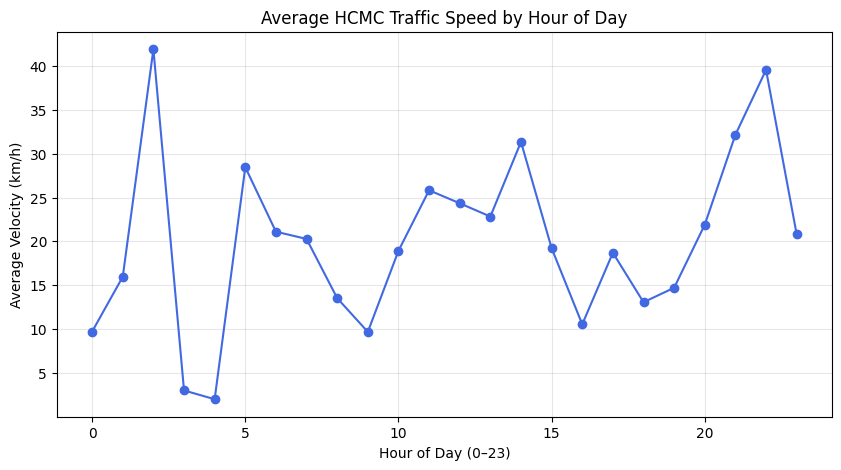

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Convert to datetime and extract hour of day (0–23)
segment_status["updated_at"] = pd.to_datetime(segment_status["updated_at"], errors="coerce")
segment_status["hour"] = segment_status["updated_at"].dt.hour

# 2️⃣ Compute average velocity per hour (aggregating across all days)
hourly_mean = (
    segment_status.groupby("hour")["velocity"]
    .mean()
    .reset_index()
    .sort_values("hour")
)

# 3️⃣ Convert to NumPy for the simulator
city_hourly_speed = hourly_mean["velocity"].to_numpy()

print("✅ city_hourly_speed shape:", city_hourly_speed.shape)
print(hourly_mean.head())

# 4️⃣ Visualize
plt.figure(figsize=(10,5))
plt.plot(hourly_mean["hour"], hourly_mean["velocity"], marker="o", color="royalblue")
plt.title("Average HCMC Traffic Speed by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average Velocity (km/h)")
plt.grid(True, alpha=0.3)
plt.show()

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import random
from math import cos, radians


def plot_hcmc_subgraph(G_sub, title="HCMC Subgraph"):
    """
    Each edge is drawn using lat/long coordinates.
    """
    # Collect node coordinates
    longs, lats = [], []
    for n, d in G_sub.nodes(data=True):
        if "long" in d and "lat" in d and not np.isnan(d["long"]) and not np.isnan(d["lat"]):
            longs.append(d["long"])
            lats.append(d["lat"])

    if len(longs) == 0:
        print("⚠️ No valid coordinates found in subgraph.")
        return

    # Plot setup
    plt.figure(figsize=(8, 8))
    for u, v, data in G_sub.edges(data=True):
        try:
            n1, n2 = G_sub.nodes[u], G_sub.nodes[v]
            if (
                "long" in n1 and "lat" in n1 and
                "long" in n2 and "lat" in n2 and
                not np.isnan(n1["long"]) and not np.isnan(n2["long"])
            ):
                plt.plot(
                    [n1["long"], n2["long"]],
                    [n1["lat"], n2["lat"]],
                    color="gray", linewidth=0.6, alpha=0.7
                )
        except KeyError:
            continue

    plt.scatter(longs, lats, s=5, color="red", alpha=0.7, label="Nodes")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

def normalize_geo_graph(G_sub):
    all_longs = np.array([d["long"] for _, d in G_sub.nodes(data=True)])
    all_lats  = np.array([d["lat"]  for _, d in G_sub.nodes(data=True)])
    min_long, min_lat = all_longs.min(), all_lats.min()

    # approximate conversion factors (for HCMC ~ latitude ~ 10°N, use cos(10°))
    meters_per_deg_lat  = 111_000
    meters_per_deg_long = 111_000 * cos(radians(10.0))

    for n, d in G_sub.nodes(data=True):
        d["x"] = (d["long"] - min_long) * meters_per_deg_long
        d["y"] = (d["lat"]  - min_lat ) * meters_per_deg_lat

    return G_sub

def plot_xy_graph(G, title="Normalized Graph"):
    plt.figure(figsize=(7, 7))
    for u, v, d in G.edges(data=True):
        n1, n2 = G.nodes[u], G.nodes[v]
        plt.plot([n1["x"], n2["x"]], [n1["y"], n2["y"]],
                 color="gray", linewidth=0.8)
    xs = [d["x"] for _, d in G.nodes(data=True)]
    ys = [d["y"] for _, d in G.nodes(data=True)]
    plt.scatter(xs, ys, s=8, color="red")
    plt.title(title)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.grid(True)
    plt.show()

def scale_graph_to_tile_units(G, real_meters_per_tile=2000.0):
    scale = 1.0 / real_meters_per_tile
    G_scaled = G.copy()
    for n, data in G_scaled.nodes(data=True):
        data["x"] *= scale
        data["y"] *= scale
    return G_scaled

def center_graph(G):
    xs = [data["x"] for _, data in G.nodes(data=True)]
    ys = [data["y"] for _, data in G.nodes(data=True)]
    x_offset, y_offset = np.mean(xs), np.mean(ys)
    for n, data in G.nodes(data=True):
        data["x"] -= x_offset
        data["y"] -= y_offset

🗺️ Tile (np.int64(4), np.int64(16)) — 19 nodes, 32 edges


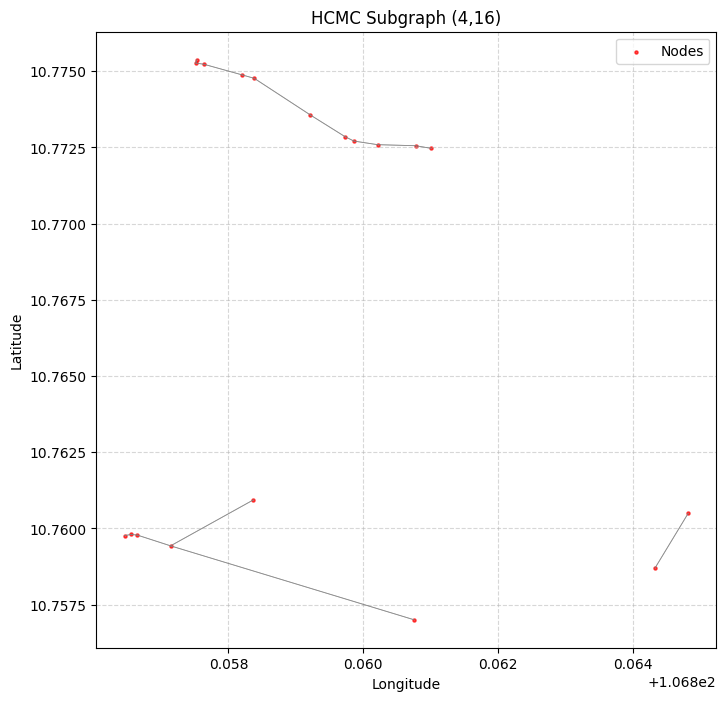

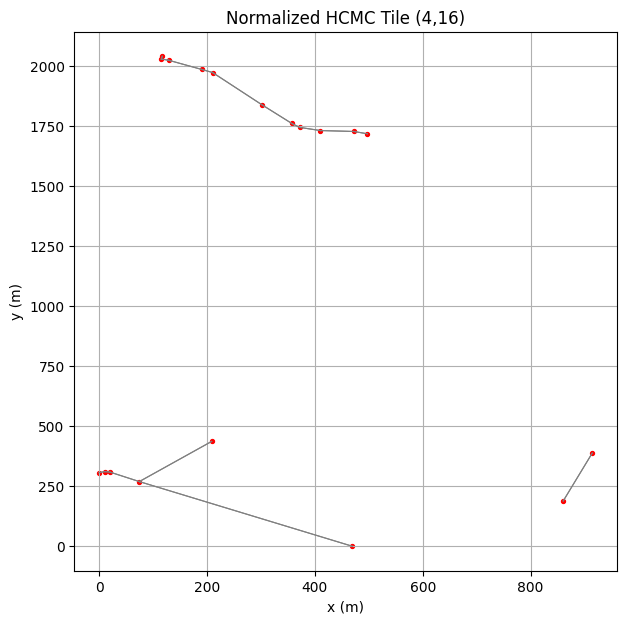

In [101]:
import networkx as nx
import json
from networkx.readwrite import json_graph


# Example usage:
(i, j) = random.choice(list(tile_graphs.keys()))
G_sub = tile_graphs[(i, j)]
print(f"🗺️ Tile {(i,j)} — {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")

plot_hcmc_subgraph(G_sub, title=f"HCMC Subgraph ({i},{j})")


# normalize your graph
G_norm = normalize_geo_graph(G_sub) 

plot_xy_graph(G_norm, f"Normalized HCMC Tile ({i},{j})")

G_vis = scale_graph_to_tile_units(G_norm)
center_graph(G_vis)


# Assume G is your graph with node attributes: x, y, (and maybe long, lat)
# 3) Export just as JSON
data = json_graph.node_link_data(G_vis)
with open(f"hcmc_map_{i}_{j}.json", "w") as f:
    json.dump(data, f, indent=2)

/Users/davestran/Desktop/CS-3331/World-Model-Project/worldmodel31/lib/python3.12/site-packages/networkx/readwrite/json_graph/node_link.py:145: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [106]:
import os
from pathlib import Path

# Choose your output folder name
output_folder = "hcmc_map_tiles"

# Create the folder if it doesn't exist yet
Path(output_folder).mkdir(parents=True, exist_ok=True)

# Now export all your tile graphs into that folder
import json
import networkx as nx
from networkx.readwrite import json_graph

for (i, j), G_sub in tile_graphs.items():
    print(f"🗺️ Exporting tile {(i, j)} — {G_sub.number_of_nodes()} nodes, {G_sub.number_of_edges()} edges")

    G_norm = normalize_geo_graph(G_sub)
    G_vis  = scale_graph_to_tile_units(G_norm)
    center_graph(G_vis)

    data = json_graph.node_link_data(G_vis)
    fname = f"{output_folder}/hcmc_map_tile_{i}_{j}.json"
    with open(fname, "w") as f:
        json.dump(data, f, indent=2)

🗺️ Exporting tile (np.int64(4), np.int64(0)) — 91 nodes, 141 edges
🗺️ Exporting tile (np.int64(4), np.int64(9)) — 315 nodes, 527 edges
🗺️ Exporting tile (np.int64(5), np.int64(1)) — 441 nodes, 876 edges
🗺️ Exporting tile (np.int64(8), np.int64(0)) — 35 nodes, 68 edges
🗺️ Exporting tile (np.int64(3), np.int64(13)) — 38 nodes, 74 edges
🗺️ Exporting tile (np.int64(5), np.int64(10)) — 250 nodes, 323 edges
🗺️ Exporting tile (np.int64(8), np.int64(9)) — 378 nodes, 553 edges
🗺️ Exporting tile (np.int64(10), np.int64(6)) — 86 nodes, 170 edges
🗺️ Exporting tile (np.int64(9), np.int64(8)) — 405 nodes, 562 edges
🗺️ Exporting tile (np.int64(0), np.int64(5)) — 60 nodes, 118 edges
🗺️ Exporting tile (np.int64(2), np.int64(2)) — 241 nodes, 444 edges
🗺️ Exporting tile (np.int64(0), np.int64(14)) — 29 nodes, 54 edges
🗺️ Exporting tile (np.int64(2), np.int64(11)) — 12 nodes, 22 edges
🗺️ Exporting tile (np.int64(6), np.int64(2)) — 444 nodes, 880 edges
🗺️ Exporting tile (np.int64(7), np.int64(1)) — 316 nod